In [1]:
from google.colab import files
files.upload() # kaggle.json for API config

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devanlucian","key":"77ccc50457692888b94c7911dd7fc30c"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle #Create the directory
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd #Print Working Directory
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd
!unzip driver-drowsiness-dataset-ddd

Streaming output truncated to the last 5000 lines.
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0092.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0093.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0094.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0095.png

In [3]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [5]:
from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [6]:
import imgaug.augmenters as augment

Augmentation = augment.Sequential([
    augment.Fliplr(0.5),
    augment.Affine(rotate=(-10, 10)),
    augment.GaussianBlur(sigma=(0, 3.0)),
    augment.LinearContrast((0.75, 2)),
    augment.Multiply((0.8, 1.2), per_channel=0.2)
])

In [7]:
Images = []
Labels  = []
class_names = []
image_size = (224, 224)
Dataset_Path = '/content/Driver Drowsiness Dataset (DDD)'

def Create_Dataset():
  for path, subdirs, files in os.walk(Dataset_Path):
    num_to_select = int(len(files) * 0.1)
    selected_files = random.sample(files, num_to_select)

    for name in tqdm(selected_files):
        img_path = os.path.join(path, name)
        if img_path.endswith("png"):
            image_read = cv2.imread(img_path)
            image_RGB = cv2.cvtColor(image_read,cv2.COLOR_BGR2RGB)
            image_resized = cv2.resize(image_RGB, image_size, cv2.INTER_CUBIC)

            image_batch = np.expand_dims(image_resized, axis=0)
            image_augmented = Augmentation(images=image_batch)
            image_Final = image_augmented[0]

            path_parts = path.split('/')
            label = path_parts[-1]

            if label not in class_names:
                class_names.append(label)

            Images.append(image_Final)
            index = class_names.index(label)
            Labels.append(index)
      # break

In [8]:
Create_Dataset()

0it [00:00, ?it/s]
100%|██████████| 1944/1944 [00:17<00:00, 113.78it/s]


In [9]:
Images = np.array(Images, dtype='float32')
Labels = np.array(Labels)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(Images, Labels, test_size=0.2, shuffle=True, random_state=69)

In [11]:
X_trainVal, X_testVal, y_trainVal, y_testVal = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=69)

In [12]:
del Images
del Labels

In [13]:
learning_rate = 0.00001
epochs = 5
batch_size = 16

In [14]:
Effecientnet_Model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size[0], image_size[1], 3),
)

x = Effecientnet_Model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=Effecientnet_Model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

258076736/258076736 [==============================] - 8s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)   

In [15]:
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_trainVal, y_trainVal),
    batch_size=batch_size
)

Epoch 1/5
209/209 [==============================] - 217s 357ms/step - loss: 0.5796 - accuracy: 0.7388 - val_loss: 0.1751 - val_accuracy: 0.9450
Epoch 2/5
209/209 [==============================] - 66s 315ms/step - loss: 0.2046 - accuracy: 0.9171 - val_loss: 0.0641 - val_accuracy: 0.9809
Epoch 3/5
209/209 [==============================] - 66s 315ms/step - loss: 0.1242 - accuracy: 0.9518 - val_loss: 0.0375 - val_accuracy: 0.9904
Epoch 4/5
209/209 [==============================] - 66s 318ms/step - loss: 0.0790 - accuracy: 0.9707 - val_loss: 0.0277 - val_accuracy: 0.9880
Epoch 5/5
209/209 [==============================] - 66s 317ms/step - loss: 0.0516 - accuracy: 0.9823 - val_loss: 0.0190 - val_accuracy: 0.9928


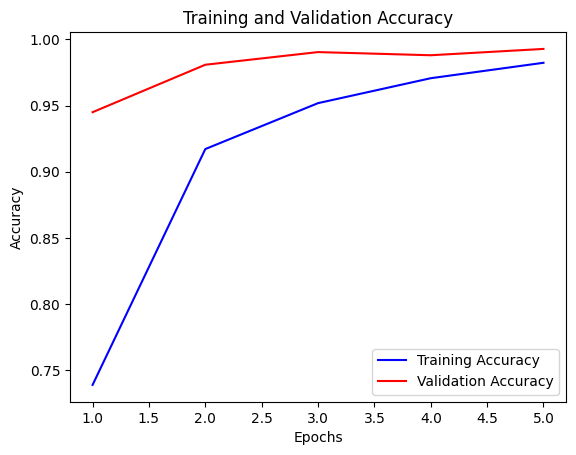

In [16]:
Training_Accuracy = history.history['accuracy']
Validation_Accuracy = history.history['val_accuracy']

epochs = range(1, len(Training_Accuracy)+1)
plt.plot(epochs, Training_Accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, Validation_Accuracy, 'r', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

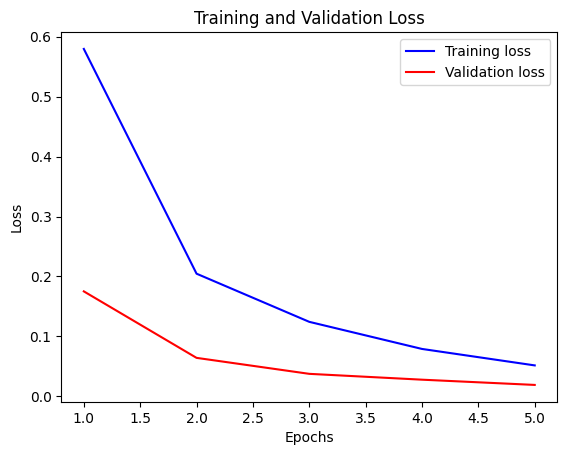

In [17]:
Train_loss = history.history['loss']
Validation_loss = history.history['val_loss']

epochs = range(1, len(Train_loss)+1)
plt.plot(epochs, Train_loss, 'b', label='Training loss')
plt.plot(epochs, Validation_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

def print_confusion_matrix(y_true, y_pred):
    Confusion_Matrix = confusion_matrix(y_true, y_pred)
    print('True Positive = ', Confusion_Matrix[0][0])
    print('False Positive = ', Confusion_Matrix[0][1])
    print('False Negative = ', Confusion_Matrix[1][0])
    print('True Negative = ', Confusion_Matrix[1][1])
    print('\n')
    df_cm = pd.DataFrame(Confusion_Matrix, range(2), range(2))
    sb.set(font_scale=1.4) # for label size
    sb.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Negative', 'Positive'], size = 16)
    plt.yticks(np.arange(2), ['Negative', 'Positve'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (Confusion_Matrix[0][0]+Confusion_Matrix[1][1])/(Confusion_Matrix[0][0]+Confusion_Matrix[0][1]+Confusion_Matrix[1][0]+ Confusion_Matrix[1][1])
    print("Accuracy = ",calculated_acc*100)

In [19]:
Prediction = model.predict(X_test)

27/27 [==============================] - 10s 150ms/step


In [20]:
Prediction = np.argmax(Prediction, axis=1)

In [21]:
BinaryLabels_Prediction = (Prediction >= 0.5).astype(int).flatten()

True Positive =  460
False Positive =  3
False Negative =  3
True Negative =  370




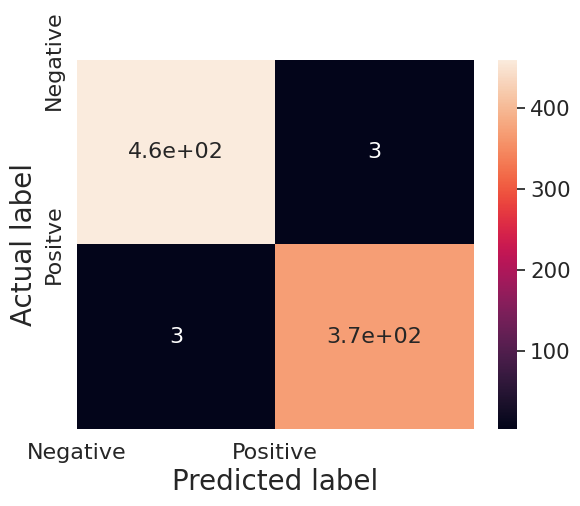

Accuracy =  99.28229665071771


In [22]:
print_confusion_matrix(y_test, BinaryLabels_Prediction)

In [23]:
print("Classification Report:\n", classification_report(y_test, BinaryLabels_Prediction))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       463
           1       0.99      0.99      0.99       373

    accuracy                           0.99       836
   macro avg       0.99      0.99      0.99       836
weighted avg       0.99      0.99      0.99       836



In [ ]:
import torch
torch.save(model, 'EffNet_Thingy.pt')